In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import glob
import os
import geopandas as gpd
from plotnine import *

# Initial Visualization: Time series of Yield

In [ ]:
results = pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet", engine="fastparquet")
results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
import matplotlib.dates as mdates

results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])

possible_vars = ['MaizeYield','SoyBeanYield','Yield','Nitrogen_Sowing']

@interact(variable=possible_vars)
def plot_variable(variable="SurfaceOrganicMatter.Cover"):
    pivot_df = results.pivot_table(
        index="Clock.Today",
        columns="Nitrogen",
        values=variable,
        aggfunc="max"
    )

    plt.figure(figsize=(12, 6))
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f"Nitrogen {col}")

    # Force all years on x-axis
    years = pd.DatetimeIndex(pivot_df.index).year.unique()
    plt.xticks(pd.to_datetime([f'{year}-01-01' for year in years]), years, rotation=45)

    plt.xlabel("Year")
    plt.ylabel(variable)
    plt.title(f"{variable} over time")
    plt.legend(title="Simulation", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='variable', options=('MaizeYield', 'SoyBeanYield', 'Yield', 'Nitrog…

# GTD - Ground Truth Data

In [40]:
GTD=pd.read_csv("/workspace/workflow/_6EvaluationNotebooks/GTD.csv")


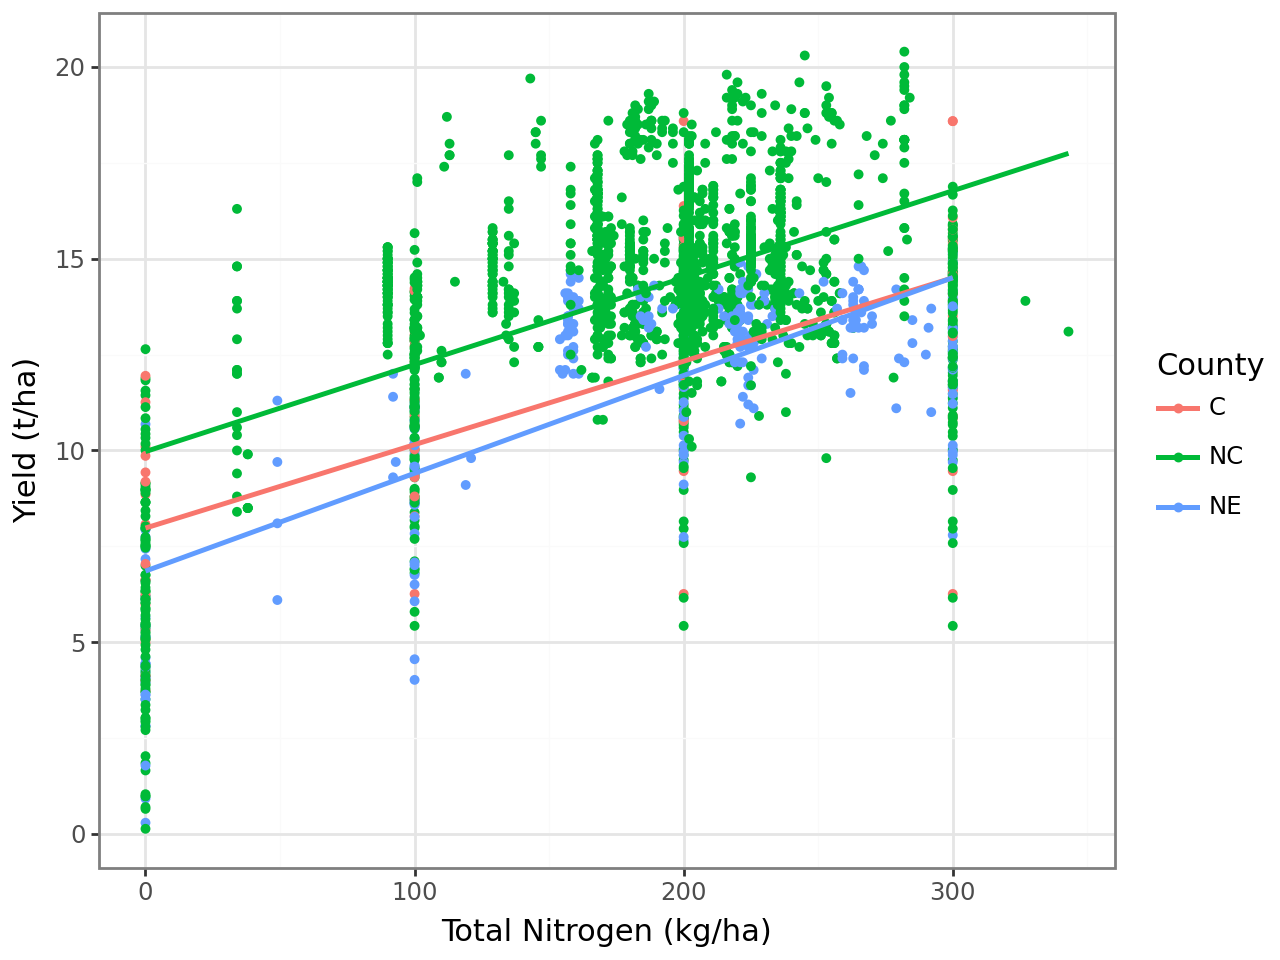

In [41]:
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme_bw

plot = (
    ggplot(GTD, aes(x='NKg_Ha', y='yield_ton', color='region')) +
    geom_point(size=1) +
    geom_smooth(method='lm', se=False) +
    theme_bw() +
    labs(
        x='Total Nitrogen (kg/ha)',
        y='Yield (t/ha)',
        color='County'
    )
)

plot.show()

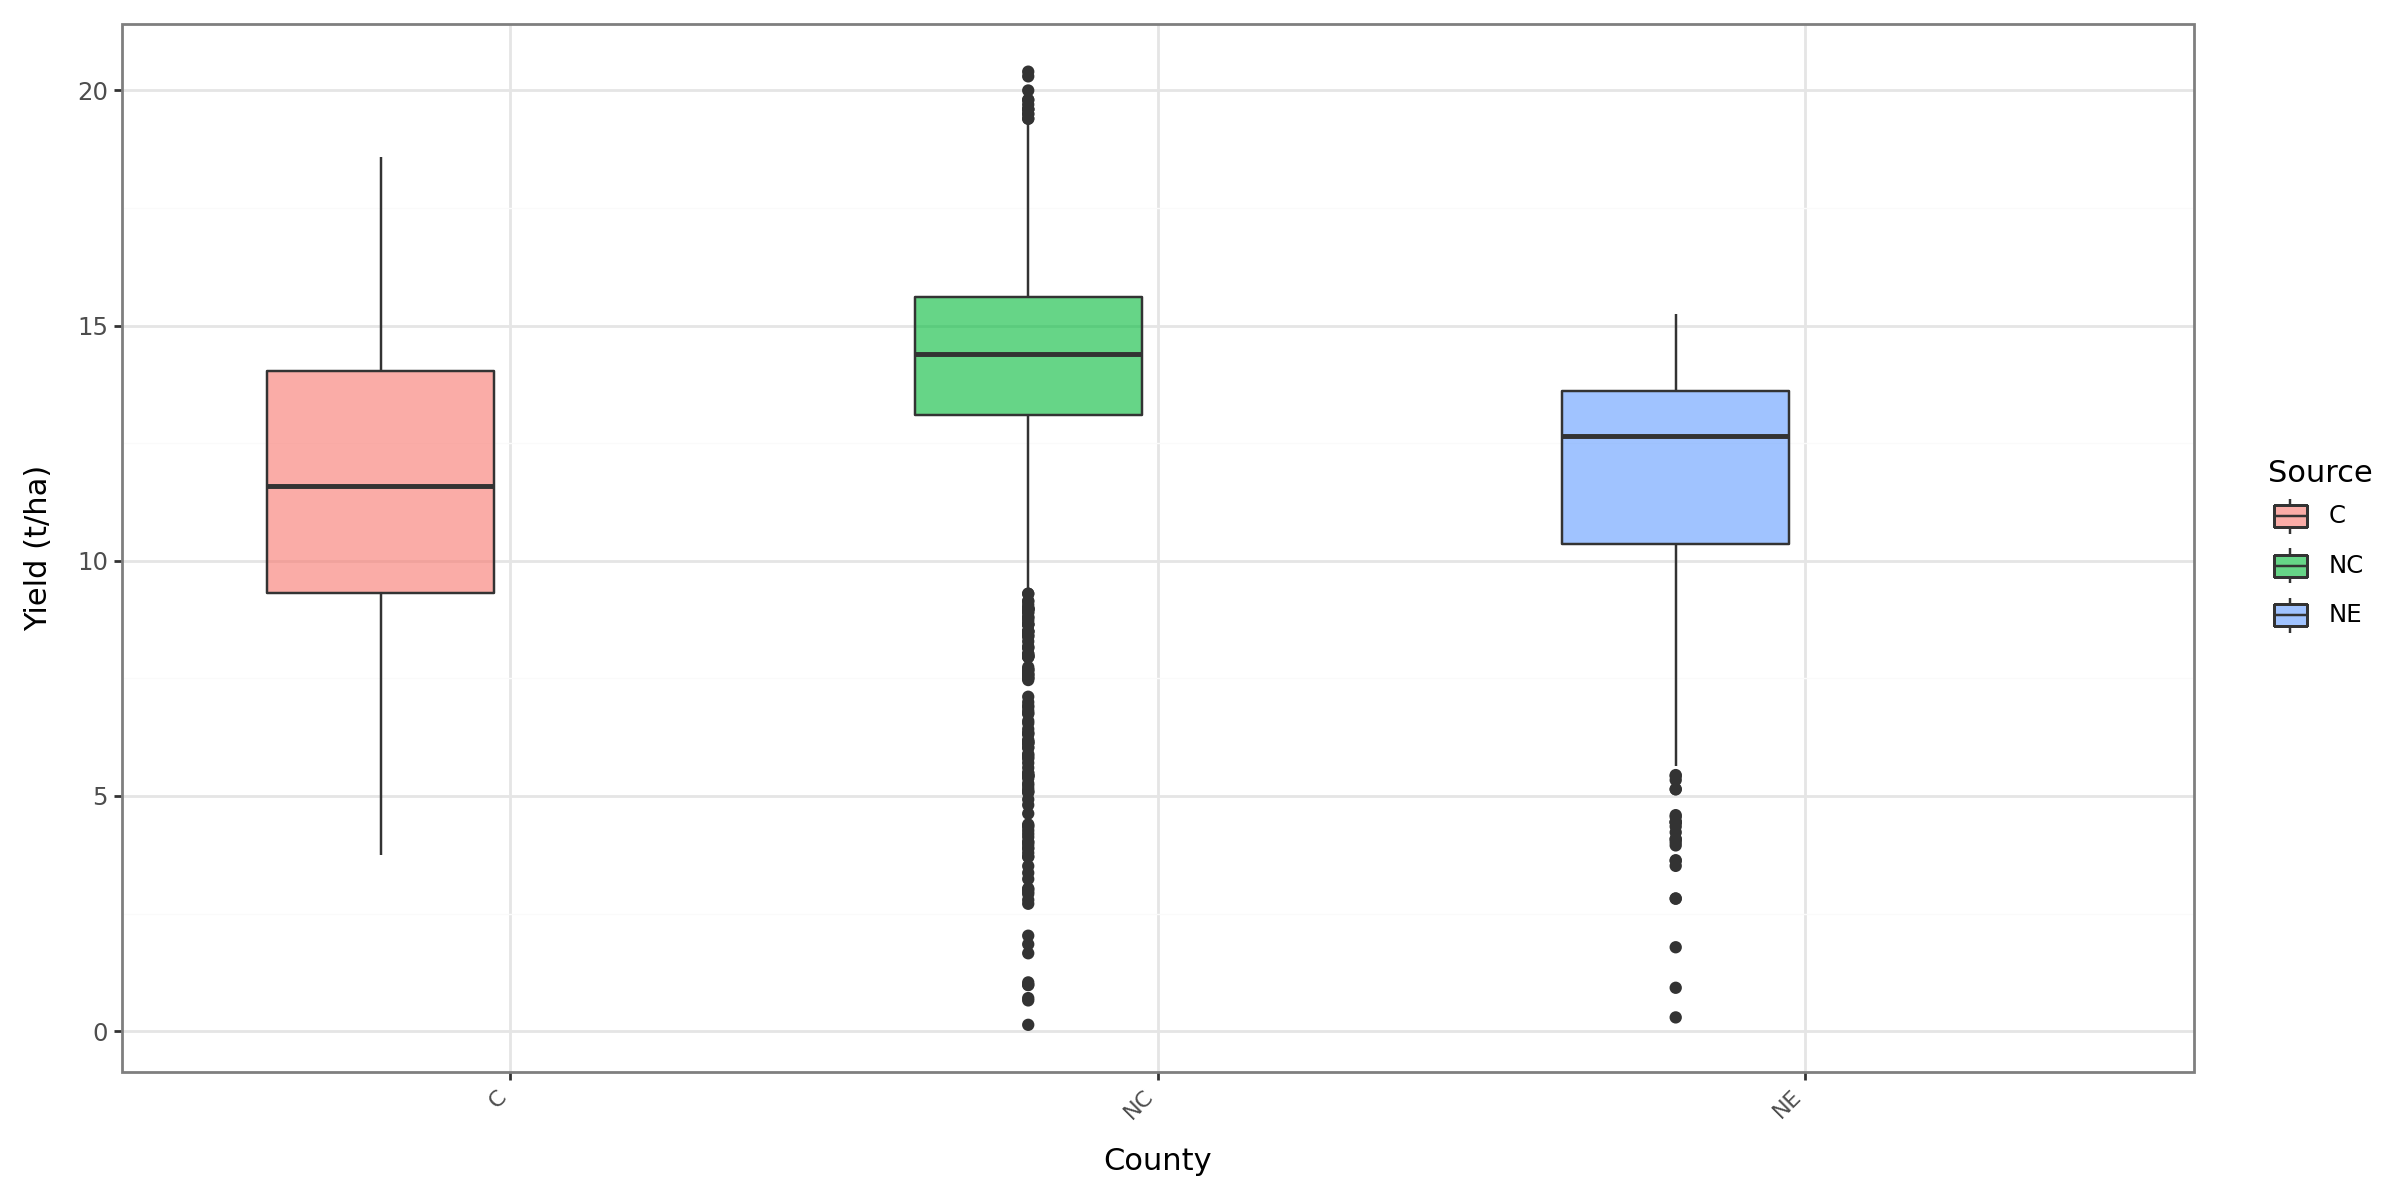

In [42]:
from plotnine import *
plot = (
    ggplot() +
    # Boxplots de valores observados
    geom_boxplot(
        data=GTD,
        mapping=aes(x='region', y='yield_ton', fill="region"),
        position=position_nudge(x=-0.2),
        width=0.35,
        alpha=0.6
    ) +
    theme_bw() +
    labs(
        x='County',
        y='Yield (t/ha)',
        fill='Source'
    )+
    theme(
        axis_text_x=element_text(size=8, angle=45, hjust=1),  # 🔹 tamaño y rotación
        figure_size=(12, 6)  # 🔹 hace el gráfico más ancho directamente
    )
)

plot.show()

# Comparation

In [43]:
# Loading fields 
folder = "/workspace/workflow/_3AgroDataExtraction"
geojson_file = glob.glob(os.path.join(folder, "*.geojson"))
fields=gpd.read_file(geojson_file[0])
fields_region=fields[['id_cell','id_within_cell','region']]
fields_region_indexed = fields_region.set_index(['id_cell', 'id_within_cell'])

In [44]:
results = results[['Clock.Today','Yield','Nitrogen','id_cell','id_within_cell','MaizeYield','SoyBeanYield']]
results_region = results.join(fields_region_indexed, on=['id_cell', 'id_within_cell'])
# Setting Dates
results_region['Clock.Today'] = pd.to_datetime(results_region['Clock.Today'])
results_region['Year'] = results_region['Clock.Today'].dt.year
# Selecting the max yield per year
idx = results_region.groupby(['Year', 'id_cell', 'Nitrogen'])['Yield'].idxmax()
highest_yield = results_region.loc[idx].reset_index(drop=True)
highest_yield['Yield'] = (highest_yield['MaizeYield']+highest_yield['SoyBeanYield'])/1000


Merging Dataframes

In [ ]:
# Deleting years 2019 and 2020 (No have GTD for thes years)
mask_c= (highest_yield['region'] == 'C') & (highest_yield['Year'] < 2014)
mask_other= (highest_yield['region'] != 'C') & (highest_yield['Year'] < 2019)
highest_yield_filtered_c= highest_yield[mask_c]
highest_yield_filtered_other= highest_yield[mask_other]
highest_yield_filtered=highest_yieliltqweqweqwsdfsdfsdfsdfsdfsdfsdasdasdassdgahhfdhcfgergergergegwer32rhhered_c.merge(highest_yield_filtered_other,how='outer')
# Selecting only the years where cron was produced
highest_yield_filtered=highest_yield_filtered[highest_yield_filtered['MaizeYield']!=0]

In [46]:
mask_GTD=(GTD['year'] < 2019) 

GTD_filtered = GTD[mask_GTD]
GTD_filtered['Yield'] = GTD_filtered['yield_ton']  

/tmp/ipykernel_612/794231599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
# SPLITING BY RANGES OF NITROGEN RATES
sim0=highest_yield_filtered[(highest_yield_filtered['Nitrogen']==0)&(highest_yield_filtered['Yield']!=0)]
sim100=highest_yield_filtered[(highest_yield_filtered['Nitrogen']==100)&(highest_yield_filtered['Yield']!=0)]
sim200=highest_yield_filtered[(highest_yield_filtered['Nitrogen']==200)&(highest_yield_filtered['Yield']!=0)]
sim300=highest_yield_filtered[(highest_yield_filtered['Nitrogen']==300)&(highest_yield_filtered['Yield']!=0)]

real0=GTD_filtered[GTD_filtered['NKg_Ha']==0]
real100=GTD_filtered[GTD_filtered['NKg_Ha']==100]
real200=GTD_filtered[GTD_filtered['NKg_Ha']==200]
real300=GTD_filtered[GTD_filtered['NKg_Ha']==300]


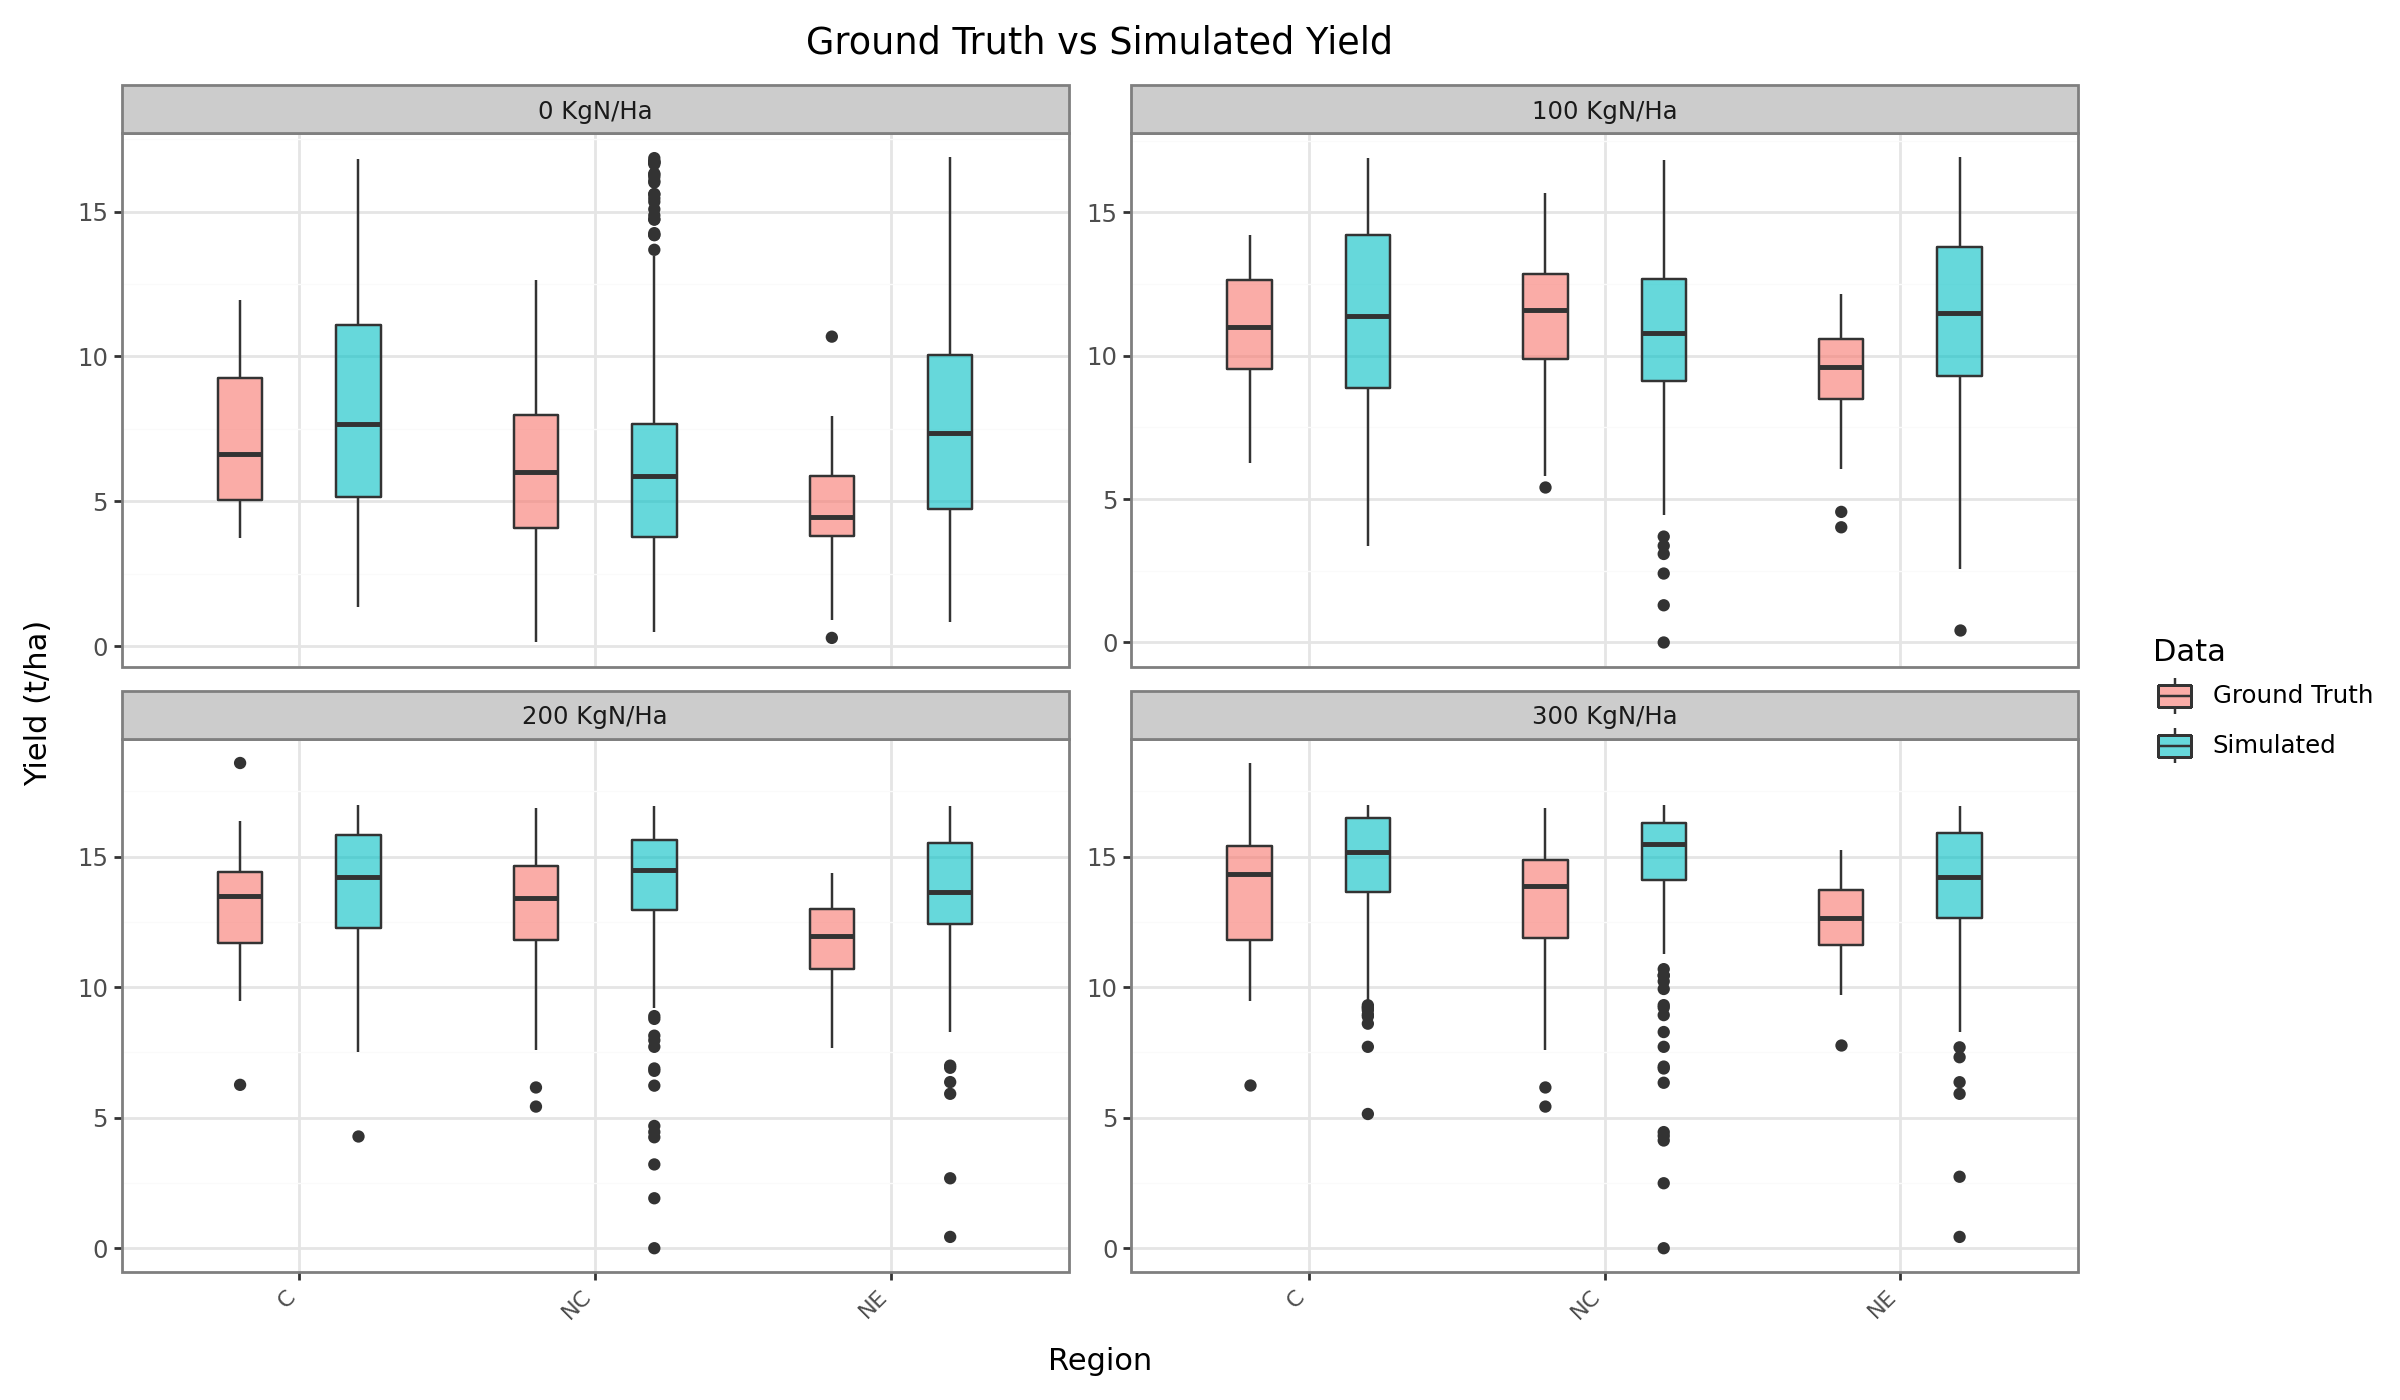

In [48]:
# Function to prepare data for a given rate
def prep_data(real, sim, rate):
    real_df = real.copy()
    real_df['Source'] = 'Ground Truth'
    real_df['Rate'] = f'{rate} KgN/Ha'
    
    sim_df = sim.copy()
    sim_df['Source'] = 'Simulated'
    sim_df['Rate'] = f'{rate} KgN/Ha'
    
    return pd.concat([real_df, sim_df], axis=0)

# Build one single dataframe with all rates
plot_data = pd.concat([
    prep_data(real0,   sim0,   0),
    prep_data(real100, sim100, 100),
    prep_data(real200, sim200, 200),
    prep_data(real300, sim300, 300)
])

plot = (
    ggplot(plot_data, aes(x='region', y='Yield', fill='Source')) +
    geom_boxplot(position=position_dodge(width=0.8), width=0.3, alpha=0.6) +
    facet_wrap('~Rate', ncol=2, scales='free_y') +
    theme_bw() +
    labs(
        title='Ground Truth vs Simulated Yield',
        x='Region',
        y='Yield (t/ha)',
        fill='Data'
    ) +
    theme(
        axis_text_x=element_text(size=8, angle=45, hjust=1),
        figure_size=(12, 7)
    )
)

plot


In [49]:
sim300[sim300['Yield']<2]

,Clock.Today,Yield,Nitrogen,id_cell,id_within_cell,MaizeYield,SoyBeanYield,region,Year
421,2007-08-29,0.433635,300,987,1,433.635,0.0,NE,2007
669,2008-07-07,0.000049,300,574,4,0.049,0.0,NC,2008


In [50]:
grouped_df = pd.DataFrame(highest_yield.groupby(['Nitrogen', 'region','id_cell','id_within_cell'])['Yield'].mean())
grouped_df = (
    highest_yield
        .groupby(['Nitrogen', 'region', 'id_cell', 'id_within_cell','Year'], as_index=False)
        .agg({'Yield': 'mean'})
)


In [51]:
grouped_df.to_csv('/workspace/workflow/_6EvaluationNotebooks/finaldata.csv',index=False)

In [52]:
import pandas as pd
pd.set_option('display.max_columns', 100)
soils=pd.read_csv('/workspace/soil/soils.csv')
soils

,SAND,CLAY,SILT,BD,KSAT,SAT,DUL,LL,AirDry,PO,SWCON,CONA,DiffusConst,XF_maize,KL_maize,e,PH,CO,FBiom,FIner,RootCN,SoilCN,RootWt,SW,no3kgha,nh4kgha,CEC,THICK,id_cell,id_within_cell
0,13.0,14.0,73.0,1.52,7.994793,0.392000,0.260,0.102,0.09180,0.426415,0.390265,3.600,40,1.0,0.080000,0.5,7.41,0.901163,0.11,0.40,45,13,1000,0.260,0,0,13.0,180.0,142,3
1,6.0,31.0,63.0,1.71,3.657679,0.352273,0.325,0.193,0.19300,0.354717,0.083777,4.000,40,1.0,0.065911,0.5,7.41,0.290698,0.10,0.45,45,13,1000,0.325,0,0,16.0,530.0,142,3
2,6.0,27.0,67.0,1.71,3.866995,0.352273,0.335,0.209,0.20900,0.354717,0.055585,3.925,40,1.0,0.047933,0.5,7.41,0.232558,0.09,0.55,45,13,1000,0.335,0,0,14.0,380.0,142,3
3,10.0,24.0,66.0,1.57,4.702477,0.405303,0.296,0.147,0.14700,0.407547,0.273704,3.850,40,1.0,0.036101,0.5,7.41,0.145349,0.08,0.60,45,13,1000,0.296,0,0,12.0,430.0,142,3
4,11.0,29.0,60.0,1.41,4.207155,0.439000,0.332,0.204,0.19380,0.467925,0.290484,3.975,40,1.0,0.080000,0.5,7.41,2.325581,0.11,0.40,45,13,1000,0.332,0,0,17.0,300.0,226,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,16.0,32.0,52.0,1.52,4.249952,0.424242,0.353,0.247,0.22230,0.426415,0.172168,4.000,40,1.0,0.080000,0.5,7.41,2.616279,0.11,0.40,45,13,1000,0.353,0,0,24.5,180.0,1298,2
526,17.0,33.0,50.0,1.52,4.067116,0.424242,0.353,0.247,0.23465,0.426415,0.172168,4.000,40,1.0,0.074501,0.5,7.41,2.616279,0.10,0.45,45,13,1000,0.353,0,0,24.5,180.0,1298,2
527,55.0,27.0,18.0,1.72,11.963285,0.348485,0.262,0.206,0.20600,0.350943,0.253441,3.925,40,1.0,0.054560,0.5,7.41,1.889535,0.09,0.55,45,13,1000,0.262,0,0,21.0,710.0,1298,2
528,55.0,22.0,23.0,1.68,19.678937,0.363636,0.233,0.153,0.15300,0.366038,0.363454,3.800,40,1.0,0.039264,0.5,7.41,0.436047,0.08,0.60,45,13,1000,0.233,0,0,13.5,230.0,1298,2
